In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [2]:
MHz = 2 * jnp.pi
GHz = 1e3 * MHz
kHz = 1e-3 * MHz

ms = 1
us = 1e-3 * ms

In [28]:
Nq0, Nq1 = 100, 4
Na = 40

Ec = 0.418 * GHz
Ej = 4.82 * GHz
El = 0.128 * GHz

wm = 5 * MHz
g = 100 * kHz

phi_ext = jnp.pi

phi_amp = 0.1 * 2 * jnp.pi
wpump = 2 * wm

In [29]:
q = dq.destroy(Nq0)
I = dq.eye(Nq0)
phi_zpf = (2 * Ec / El) ** 0.25
n_zpf = 1.0 / (2 * phi_zpf)
phi_op = phi_zpf * (q + q.dag())
n_op = 1j * n_zpf * (q.dag() - q)
H_harm = 4.0 * Ec * n_op @ n_op + 0.5 * El * phi_op @ phi_op
H_josep = -Ej * dq.cosm(phi_op - phi_ext * I)
E, Q = jax.scipy.linalg.eigh((H_harm + H_josep).data)
U = Q[:, :Nq1]
H_harm = U.T @ H_harm.asdense().data @ U
q = dq.asqarray(U.T @ q.asdense().data @ U)


def f(t):
    phi_ext_t = (phi_ext + phi_amp * jnp.cos(t * wpump)) * I
    return dq.tensor(
        dq.asqarray(-Ej * U.T @ dq.cosm(phi_op - phi_ext_t).data @ U), dq.eye(Na)
    )


H_josep = dq.timecallable(f)
H_q = dq.tensor(H_harm, dq.eye(Na)) + H_josep

a = dq.destroy(Na)
Ha = wm * a.dag() @ a

H_cpl = g * dq.tensor(q + q.dag(), a + a.dag())
H = H_q + dq.tensor(dq.eye(Nq1), Ha) + H_cpl

/Users/remirousseau/Documents/Work/Thesis/quantum_simulations/venv/lib/python3.13/site-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
/var/folders/vl/tbcqfs6x725800q7m5nh8c4w0000gn/T/ipykernel_21616/24589432.py:9: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E, Q = jax.scipy.linalg.eigh((H_harm + H_josep).data)


In [30]:
output = dq.sesolve(H, dq.coherent((Nq1, Na), (0, 3)), jnp.linspace(0, 20 * us, 1000))

|██████████| 100.0% ◆ elapsed 4.11s ◆ remaining 0.00ms  


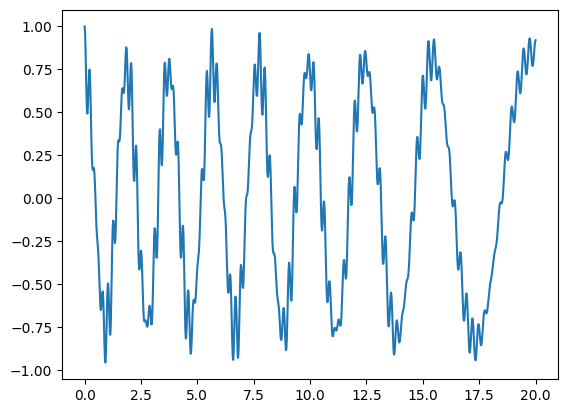

In [31]:
red_dm = dq.ptrace(output.states, 0)
sigma_z = jnp.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 0], (0, 0, 0, 0)])
plt.plot(output.tsave / us, dq.expect(sigma_z, red_dm).real, label="Qubit excitation")

100%|██████████| 50/50 [00:01<00:00, 28.36it/s]


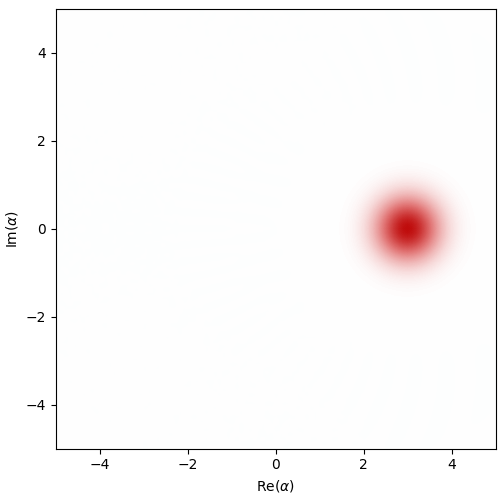

In [32]:
dq.plot.wigner_gif(dq.ptrace(output.states, 1))